## Task
Develop a system for plagarism detection, where when given a set of textual documents, detect which documents contain significant overlapping content. It is up to you to define what "significant" and "overlapping" mean. 

## Methodology

I chose to define overlapping content as the overlapping of relatively unique words within a corpus. Significant overlap was chosen to be a degree of overlap that is seen only within 5% of the population.

#### Collection
I grabbed a small sample of papers from arxiv.org as suggested and extracted the text using PDFMiner.

#### Featurization
I represented each document as a bag of words (i.e., a dictionary of word counts) and transformed these counts to tf-idf, which weights term frequency by their relative uniqueness to a corpus (and in turn, serves as a better fingerprint of a document). 

#### Distance metric
I chose cosine similarity to measure the "distance" between two documents. There are many other distance metrics available, but this is a good start. It normalizes for document length and is easy to understand.

#### Algorithm
I then computed all\* pairwise distances between every document, printed a histogram of these values as a sanity check, and then computed the 5% threshold. I then return all document pairs that lie within this threshold.

\* This is an O(n^2) computation that can be ameliorated with some suggestions below.  

#### Testing
I inserted two test documents into the corpus that were created by sampling from two documents and checked to see if they were identified. 

## Questions
* How would you assess the performance of your system?

I would create a test set of labeled documents, and compute the following metrics:

Total Accuracy: How many pairs did the system label correctly

True Positives (Precision): How accurate were the system's positive labels (aka True Positive)

False Positives: How many pairs did the system incorrectly label as being plagiarized

True Negatives: How accurate were the system's negative labels

False Negatives: How many pairs did the system incorrectly label as being unrelated

Recall: How many plagiarized pairs did the system identify out of the total positive population

* How could malicious authors potentially fool your system?

Stemming should take care of most word conjugations. Malicious actors could replace a large portion of their document with synonyms, insert suble typos to key phrases, and use a different encoding scheme. They could poison the system with very identical documents, thus pushing the 5% tolerance away from the documents they are actually trying to get accepted in the system. 

* Is your system scalable w.r.t. number of documents / users? 
If not, how would you address the scalability (in terms of algorithms, infrastructure, or both)?

The initial pairwise distance computation would not scale w.r.t. documents. I would ameliorate this by using a k-means algorithm on a large corpus, and doing initial comparisons of new documents on the k-sized set of centroids, and then do comparisons with documents only associated with that cluster. This could be scaled up to a n-level tree of centroids, if necessary. 

A large enough corpus could not be held completely in memory. At this point, vectorizing the corpus with the bag of words model would require creating a corpus dictionary, and then partitioning the words amongst separate machines, calculating the sub vectors and distances in pieces, then re-assembling them all for a final score.  

In [1]:
import codecs
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.spatial.distance import cosine
from scipy.spatial.distance import pdist
from scipy.stats import scoreatpercentile
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

In [2]:
filenames = [
    'papers/1602.02154.txt',
    'papers/1602.02155.txt',
    'papers/1602.02160.txt',
    'papers/1602.02161.txt',
    'papers/1602.02167.txt',
    'papers/1602.02183.txt',
    'papers/1602.02188.txt',
    'papers/1602.02189.txt',
    'papers/1602.02213.txt',
    'papers/1602.02217.txt',
]

def make_corpus(filenames):
    corpus = []    
    for i in filenames:
        with codecs.open(i, 'r', 'utf-8') as f:
            corpus.append(f.read())    
    return corpus

def insert_test_documents(corpus, filenames):
    """
    Insert two documents into the corpus that should be identified as plagiarism
    """
    random.seed("yewno")
    
    doc1 = corpus[0].split()
    doc2 = corpus[1].split()
    copy1 = " ".join(random.sample(doc1, len(doc1) / 2) + random.sample(doc2, len(doc2) / 2))
    copy2 = " ".join(random.sample(doc1, len(doc1) / 2) + random.sample(doc2, len(doc2) / 2))
    corpus.extend([copy1, copy2])
    filenames.extend(['copy1', 'copy2'])
    return corpus, filenames

def _make_index_pairs(n):
    indexes = []
    for i in range(0, n):
        for j in range(i+1, n):
            indexes.append((i,j))
    return indexes

def get_distance_cutoff(percentile):
    return scoreatpercentile(distances, percentile)

def get_similar_docs():
    cutoff = get_distance_cutoff(5)
    print "Cutoff: {:.2f}".format(cutoff)
    
    indexes = _make_index_pairs(len(corpus))
    similar_docs = [index for distance, index in zip(distances, indexes)
                          if distance < cutoff]
    return similar_docs

(array([  3.,   2.,   0.,   8.,  11.,  10.,  10.,  14.,   5.,   3.]),
 array([ 0.01002143,  0.06251348,  0.11500553,  0.16749758,  0.21998963,
         0.27248168,  0.32497373,  0.37746578,  0.42995783,  0.48244988,
         0.53494193]),
 <a list of 10 Patch objects>)

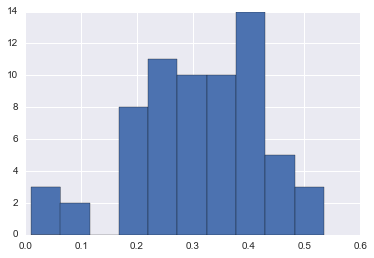

In [3]:
# Get data
corpus = make_corpus(filenames)
corpus, filenames = insert_test_documents(corpus, filenames)

# featurize
vectorizer = TfidfVectorizer(min_df=1)
results = vectorizer.fit_transform(corpus).toarray()

# calculate distances 
distances = pdist(results, 'cosine')
plt.hist(distances)

In [4]:
# Get similar documents and pretty print them
indexes = get_similar_docs()
for i in indexes:
    first_file = filenames[i[0]]
    second_file = filenames[i[1]]
    print "{} and {} look similar".format(first_file, second_file)

Cutoff: 0.09
papers/1602.02154.txt and copy1 look similar
papers/1602.02154.txt and copy2 look similar
papers/1602.02155.txt and copy2 look similar
copy1 and copy2 look similar


## Evaluation

Assuming that the documents I chose do not have significant overlapping content, but that copy1 and copy2 do, the following document pairs should be identified as likely containing plagiarism:

papers/1602.02154.txt, copy1

papers/1602.02154.txt, copy2

papers/1602.02155.txt, copy1

papers/1602.02155.txt, copy2

copy1, copy2

In [6]:
# Evaluate the performance of the system on the test data and the 5% threshold
n = len(corpus)
total_pairs = n * (n+1) / 2.0 

print "Metrics"
print "-------"
print "Accuracy: {:.2f}%".format((total_pairs - 1) / total_pairs * 100)
print "True Positives (Precision): {:.2f}%".format(4.0 / 4.0 * 100)
print "False Positives: {:.2f}%".format(0.0 / 4.0 * 100)
print "True Negatives: {:.2f}%".format(73.0 / 74.0 * 100)
print "False Negatives: {:.2f}%".format(1.0 / 74.0 * 100)
print "Recall: {:.2f}%".format(4.0 / 5.0 * 100)

Metrics
-------
Accuracy: 98.72%
True Positives (Precision): 100.00%
False Positives: 0.00%
True Negatives: 98.65%
False Negatives: 1.35%
Recall: 80.00%
